# Catalog Analysis

Este notebook presenta el análisis del catálogo de sismicidad.

In [1]:
%%time
import pandas as pd
import math

#catalogo original
fullcatalogo=pd.read_csv("https://raw.githubusercontent.com/daniel-leon/redessismos/main/catalogo-usgs-20231011.csv",sep=',',parse_dates=["time"])
#fullcatalogo=catalogo[["time","latitude","longitude","depth","mag"]]



CPU times: user 1.63 s, sys: 1.38 s, total: 3.01 s
Wall time: 20 s


Se hace un análisis del catálogo. A continuación, un análisis de quiénes contribuyeron para las localizaciones de este catálogo.

<AxesSubplot:title={'center':'Contributors to the seismicity catalog'}, xlabel='year'>

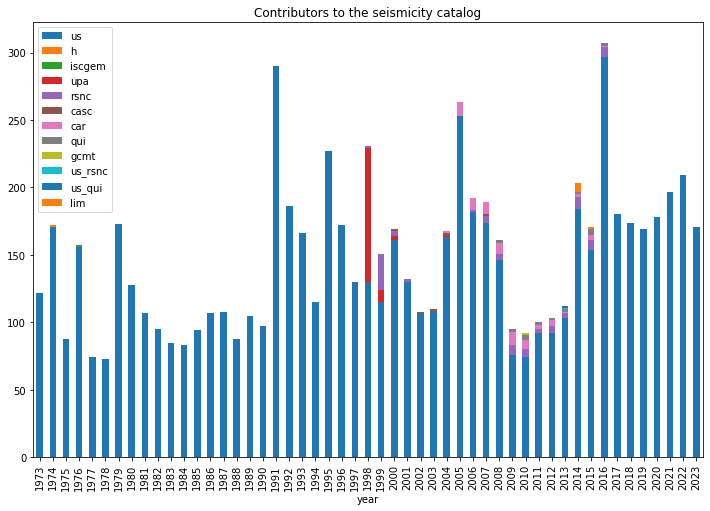

In [2]:
mmin=3.0
contributors=list(fullcatalogo[(fullcatalogo["time"]>pd.Timestamp("1973-01-01T00:00:00Z")) & (fullcatalogo["mag"]>mmin)].locationSource.unique())
anos=[i for i in range(1973,2024,1)]
salida=[]
for a in anos:
    vs=[a]
    for c in contributors:
        v=len(fullcatalogo[(fullcatalogo["time"]>str(a)+"-01-01") & (fullcatalogo["time"]<str(a+1)+"-01-01") & (fullcatalogo["locationSource"] == c) & (fullcatalogo["mag"]>mmin)])
        vs.append(v)
    salida.append(vs)
columnas=["year"]
for c in contributors:
    columnas.append(c)
dfcontribs=pd.DataFrame(salida,columns=columnas)
#xticks = anos

dfcontribs.plot.bar(x="year",figsize=(12,8),rot=90,stacked=True,title="Contributors to the seismicity catalog")

Gutenberg-Richter para seleccionar la magnitud de completitud.

/home/danileo/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


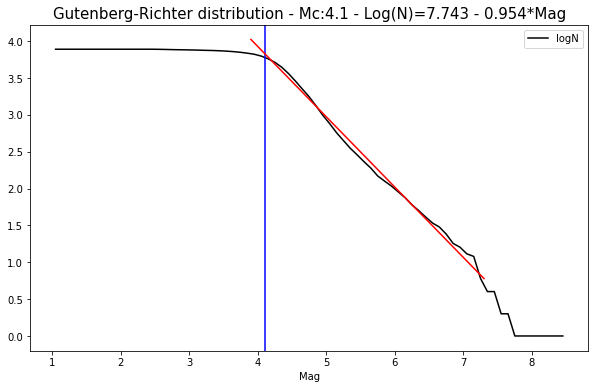

In [3]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

def gutenberg_richter(x, a, b):
    return a - b * x

fullcatalogo=fullcatalogo[fullcatalogo["time"]>pd.Timestamp("1973-01-01T00:00:00Z")]

mc=3.9
#Magnitud máxima para calcular la distribución GR
mmax=7.5
#La magnitud de completitud es la magnitud mínima mas este delta.
dmc=0.2


mmin=mc+dmc-0.001


#Se crea la distribución de magnitudes vs. N de eventos.
magnitudes=fullcatalogo.mag.values
magnitudes=magnitudes[magnitudes>=mc]
magnitudes=magnitudes[magnitudes<mmax]
magnitudes.sort()
#magnitudes

num_events = np.arange(1, len(magnitudes)+1)
cumulative_dist = num_events[::-1] #/num_events[-1]

#Se ajusta una curva a la distribución de magnitudes.
popt, pcov = curve_fit(gutenberg_richter, magnitudes, np.log10(cumulative_dist))

parama=popt[0]
y=gutenberg_richter(magnitudes,parama,popt[1])
listamags=np.arange(1.05,8.5,0.1)

listacants=[]
for lmag in listamags:
    l=(fullcatalogo.mag > lmag)
    listacants.append(sum(l))
    
#Se crea un dataframe con las magnitudes y cantidad de eventos.
gutrich=pd.DataFrame(listamags,columns=["Mag"])
gutrich.insert(len(gutrich.columns),"N",listacants)
nlogs=np.log10(gutrich.N)
gutrich.insert(len(gutrich.columns),"logN",nlogs)
gutrich["logN"]=gutrich['logN'].replace(-np.inf,0)



fig, ax1 = plt.subplots(figsize=(10,6))
gutrich.plot(x='Mag',y='logN',kind='line',ax=ax1,color='black')
plt.axvline(x=mc+dmc,color='b')
popt, pcov = curve_fit(gutenberg_richter, magnitudes, np.log10(cumulative_dist))
parama=popt[0]
y=gutenberg_richter(magnitudes,parama,popt[1])
plt.plot(magnitudes, y, 'r-', label='fit')
plt.title("Gutenberg-Richter distribution - Mc:"+str(mc+dmc)+" - Log(N)="+str(round(parama,3))+" - "+str(round(popt[1],3))+"*Mag",fontsize=15)
catalogo=fullcatalogo[fullcatalogo["mag"]>mmin]
plt.savefig("gutenberg-richter-distribution.png")

Se muestra el mapa de la sismicidad

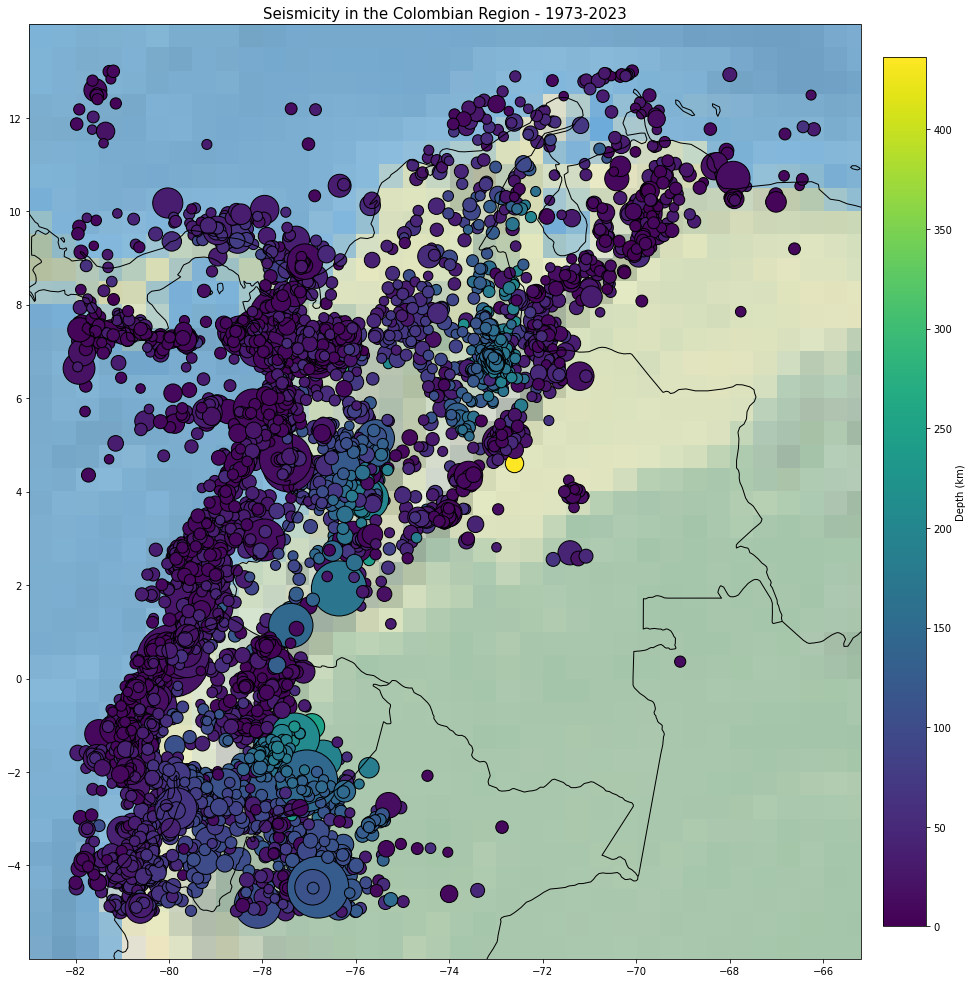

CPU times: user 1.54 s, sys: 884 ms, total: 2.43 s
Wall time: 6.28 s


In [4]:
%%time

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.pyplot as plt

catalogo=catalogo[["time","latitude","longitude","depth","mag"]]

#fig = plt.figure(figsize=(14, 7))
fig=plt.figure(figsize=(18,20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()
# Add coastlines
ax.coastlines()


ax.add_feature(cfeature.BORDERS)

# Show the entire world
#ax.set_global()
region=[min(catalogo["longitude"])-1, max(catalogo["longitude"])+1, min(catalogo["latitude"])-1, max(catalogo["latitude"])+1]

ax.set_extent(region, crs=ccrs.PlateCarree())

# Add positions of recent earthquakes, with magnitudes denoted by color 
lon=catalogo.longitude
lat=catalogo.latitude
mag=catalogo.mag
depth=catalogo.depth

sc = ax.scatter(lon,lat,s=(3 ** catalogo["mag"]), c=depth, cmap='viridis',edgecolors='black')

# Add colorbar
cbar = plt.colorbar(sc, ax=ax,shrink=0.8,pad=0.022)
cbar.set_label("Depth (km)")


ax.set_xticks([i for i in range(-82,-65,2)]) #, crs=ccrs.PlateCarree())
ax.set_yticks([i for i in range(-4,13,2)]) #, crs=ccrs.PlateCarree())

# Add title
ax.set_title("Seismicity in the Colombian Region - 1973-2023",loc='center',fontsize=15)
#ax.set_title(f"Today is: {date.today()}",loc='right')

# Display the plot
plt.show()

Se complementa el catálogo con otra información.

In [6]:
catalogo["epochs"]=(catalogo["time"]-pd.Timestamp("1970-01-01T00:00:00Z"))//pd.Timedelta('1s')
catalogo.insert(len(catalogo.columns),"energia",[math.pow(10,4.8+1.5*lin) for lin in catalogo["mag"]])
losepochs=catalogo.epochs.values
#ti=losepochs[0]
#dtiempos=[]
stiempos=[]
#dtiempos.append(0)
stiempos.append(0)

for t in range(len(losepochs)-1):
    t1=losepochs[t+1]-losepochs[t]
    #dtiempos.append(t1/(60*60*24))
    stiempos.append(t1)
    #ti=tiempos
catalogo.insert(len(catalogo.columns),"DTsegs",stiempos)
catalogo["DTdays"]=catalogo["DTsegs"]/(60*60*24)


# Graficas para analizar el catálogo

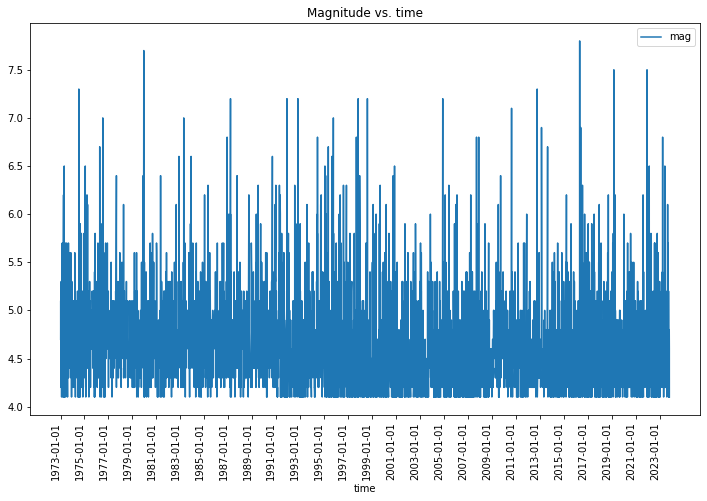

In [7]:
import matplotlib.pyplot as plt
import datetime
xticks = pd.date_range(datetime.datetime(1973,1,1), datetime.datetime(2023,10,1), freq='2YS')
ax=catalogo.plot(x="time",y="mag",title="Magnitude vs. time",figsize=(12,8),rot=90,xticks=xticks)
plt.savefig("magvstime.png")

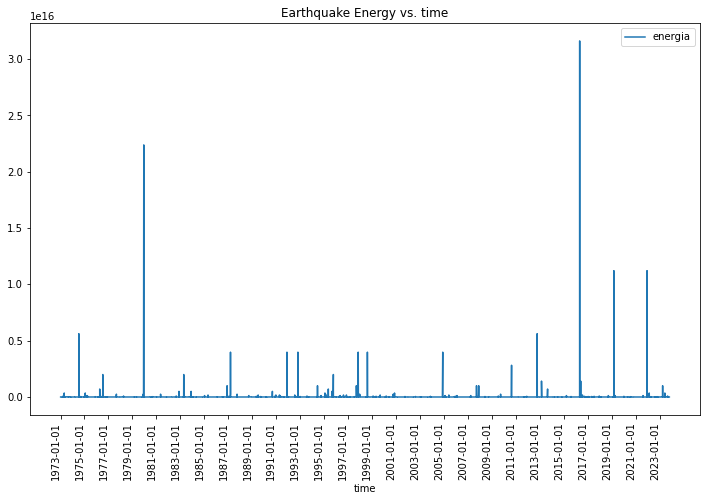

In [8]:
xticks = pd.date_range(datetime.datetime(1973,1,1), datetime.datetime(2023,10,1), freq='2YS')
catalogo.plot(x="time",y="energia",title="Earthquake Energy vs. time",figsize=(12,8),rot=90,xticks=xticks)
plt.savefig("energyvstime.png")

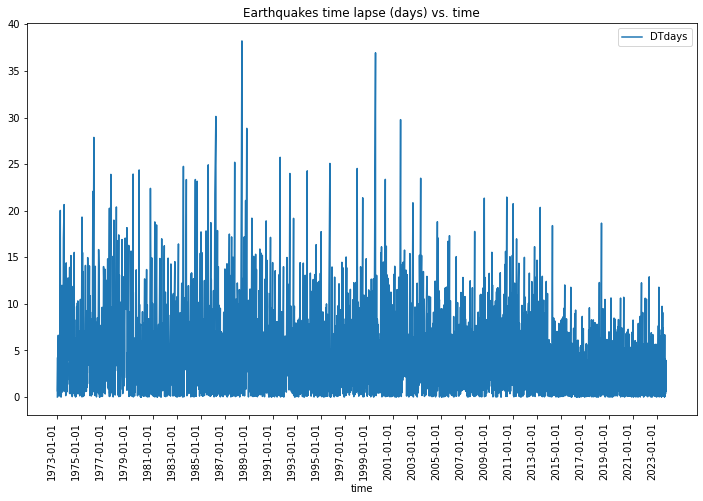

In [9]:
xticks = pd.date_range(datetime.datetime(1973,1,1), datetime.datetime(2023,10,1), freq='2YS')
ax=catalogo.plot(x="time",y="DTdays",title="Earthquakes time lapse (days) vs. time",figsize=(12,8),rot=90,xticks=xticks)
plt.savefig("timelapsevstime.png")

In [53]:
catalogo["depth"].max()

436.5

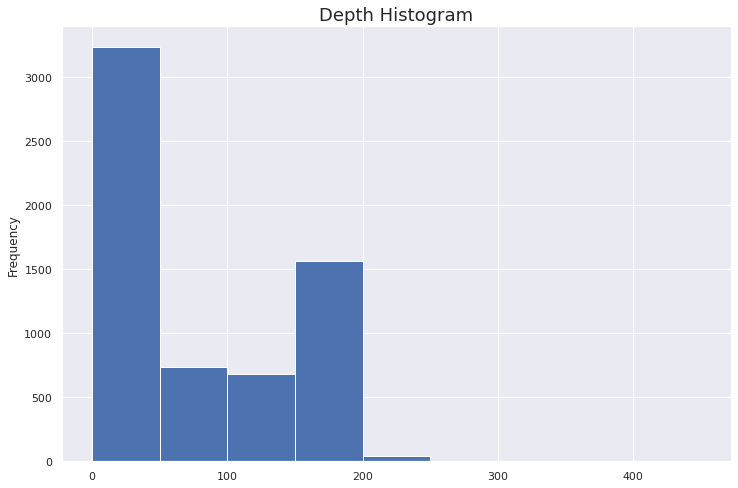

In [59]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
catalogo["depth"].plot(kind='hist',ax=ax,bins=[i for i in range(0,451,50)])
plt.title("Depth Histogram",fontsize=18)
plt.savefig("histogramamagnitud.png")

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
catalogo["DTdays"].plot(kind='hist',bins=40,ax=ax)
plt.title("Histogram of days lapse between earthquakes",fontsize=18)
plt.savefig("histogramadayslapse.png")

In [18]:
catalogo["DTdays"].quantile(q=[0.33,0.66])

0.33    0.812486
0.66    2.928452
Name: DTdays, dtype: float64

In [19]:
catalogo["mag"].quantile(q=[0.33,0.66])

0.33    4.4
0.66    4.7
Name: mag, dtype: float64

In [11]:
%%time

catalogo["energialog"]=np.log(catalogo.energia)

# se calculan vectores de energia sismica liberada

vecresultados=[]
for neventos in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:

    nsiguientes=int(neventos/2)

    #vecsismicidadeslog=[]
    #vecsismicidades=[]
    vecenergiaslog=[]
    vecenergias=[]
    dtiempos=[]
    tiempos=[]
    for i in range(len(catalogo)-neventos-nsiguientes):
        tinis=catalogo.epochs.values[i]
        tfins=catalogo.epochs.values[i+neventos-1]
        dtsegs=tfins-tinis
        energias=catalogo.energia[i:i+neventos].sum()
        vecenergias.append(energias)
        vecenergiaslog.append(np.log(energias))
        #vecsismicidadeslog.append(np.log(energias/dtsegs))
        #vecsismicidades.append(energias/dtsegs)
        tiempos.append(catalogo.time.values[i])
        dtiempos.append(dtsegs)
        vecresultados.append([neventos,catalogo.time.values[i+neventos],dtsegs,energias])

    #plt.figure(figsize=(12,4))
    #plt.plot(tiempos,vecsismicidadeslog)
    #plt.title("Seismicity from "+str(neventos)+" events")

dfvecresultados=pd.DataFrame(vecresultados,columns=["neventos","tiempo","dtsegs","energias"])
dfvecresultados["dtdias"]=dfvecresultados["dtsegs"]/(60*60*24)

dfvecresultados["sismicidad"]=dfvecresultados["energias"]/dfvecresultados["dtdias"]
dfvecresultados["sismicidadlog"]=np.log(dfvecresultados["sismicidad"])

CPU times: user 8.87 s, sys: 92.1 ms, total: 8.97 s
Wall time: 8.97 s


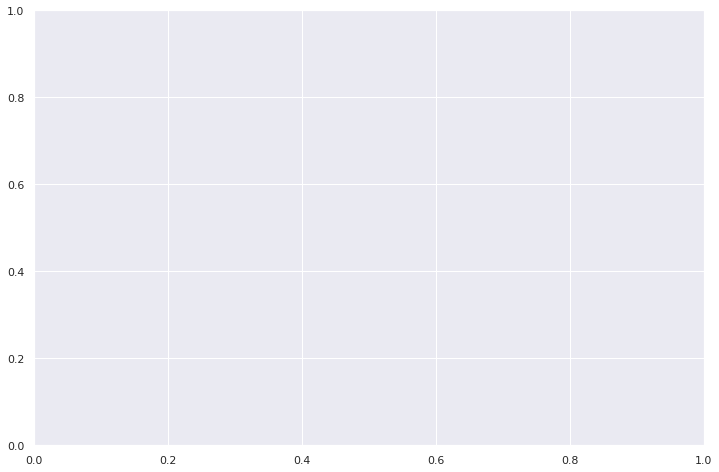

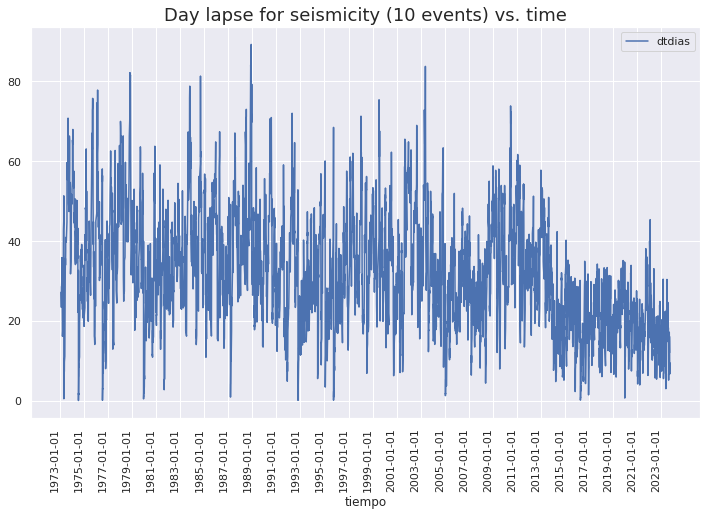

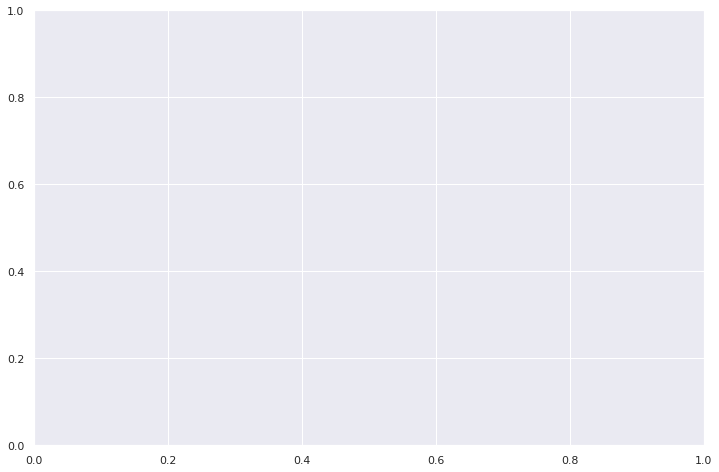

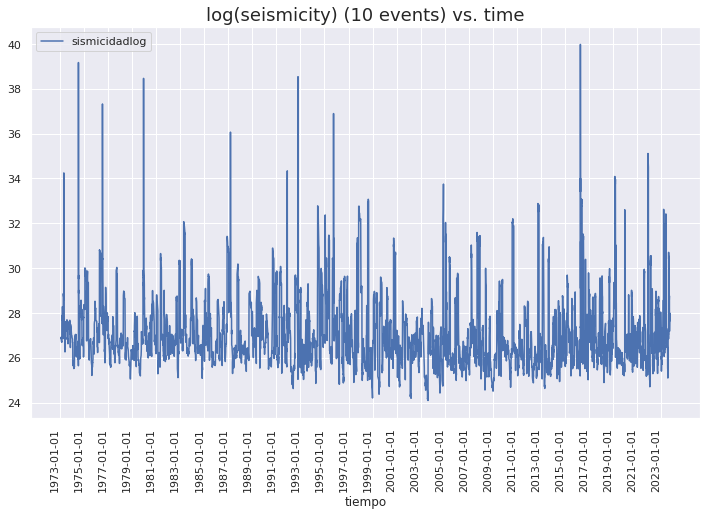

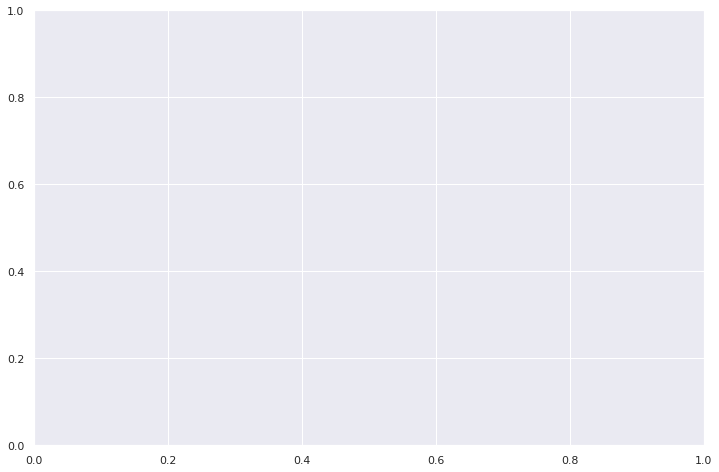

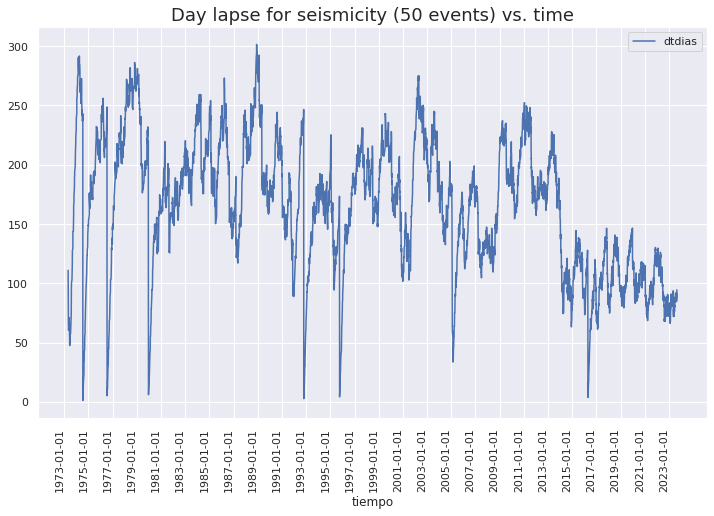

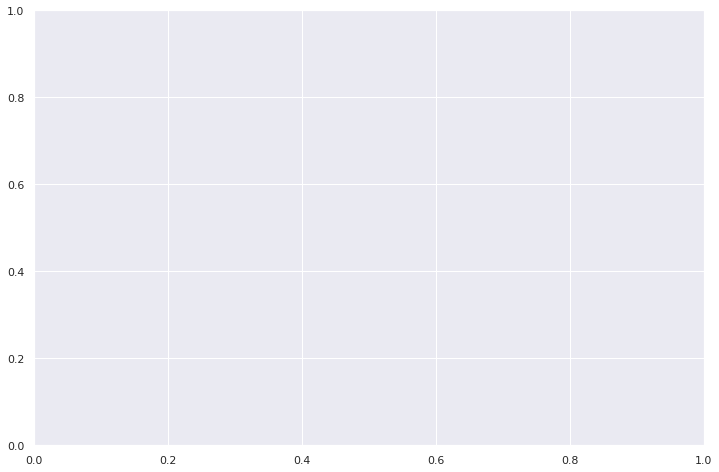

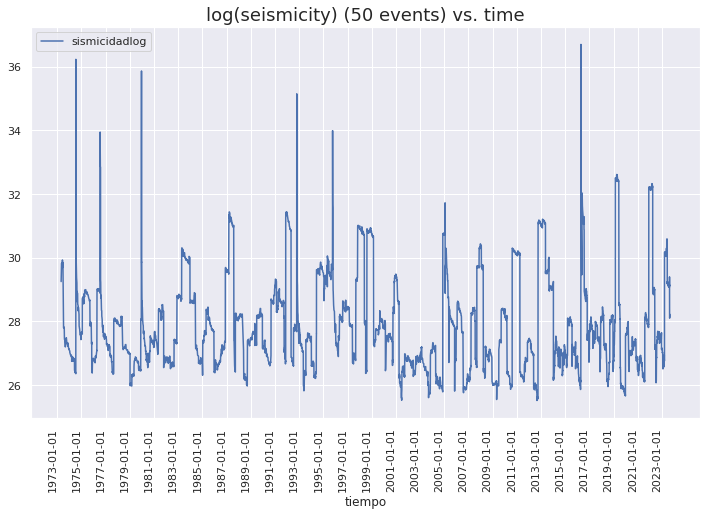

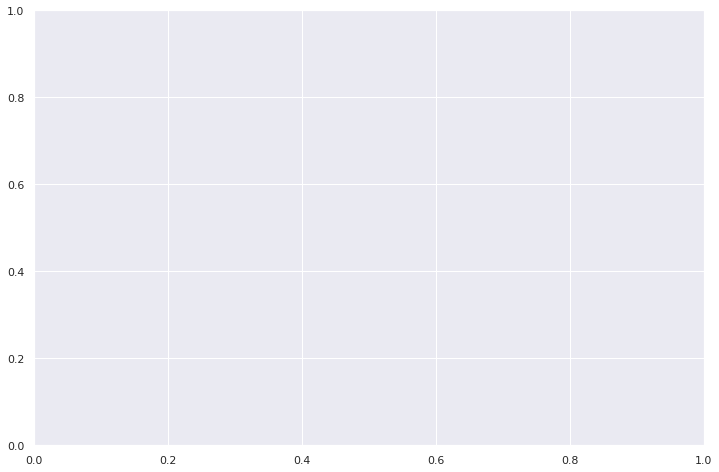

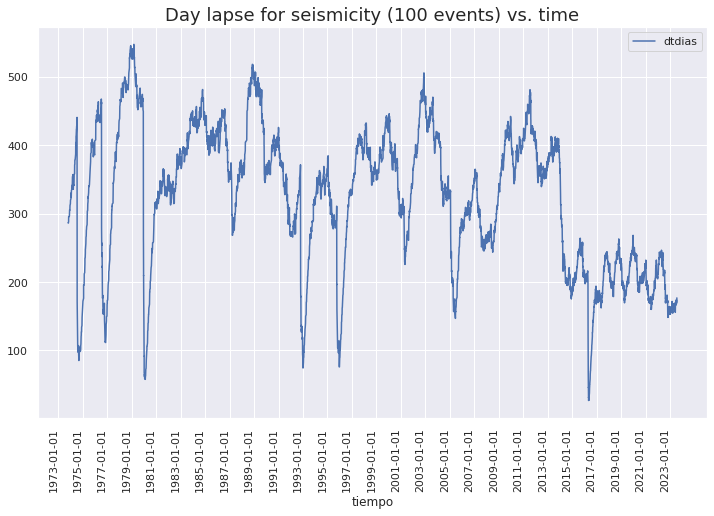

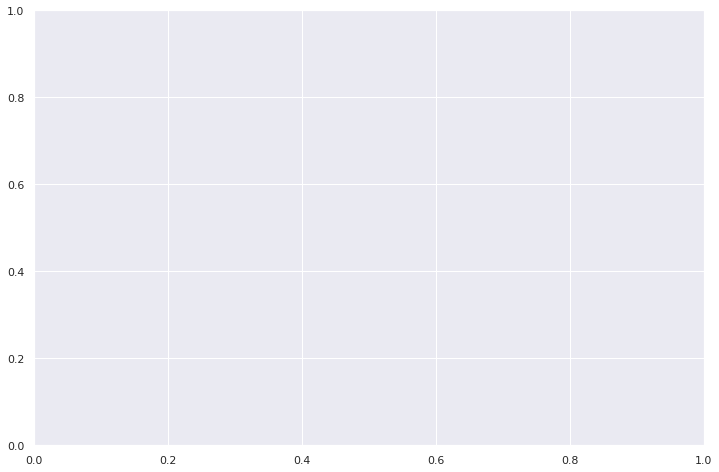

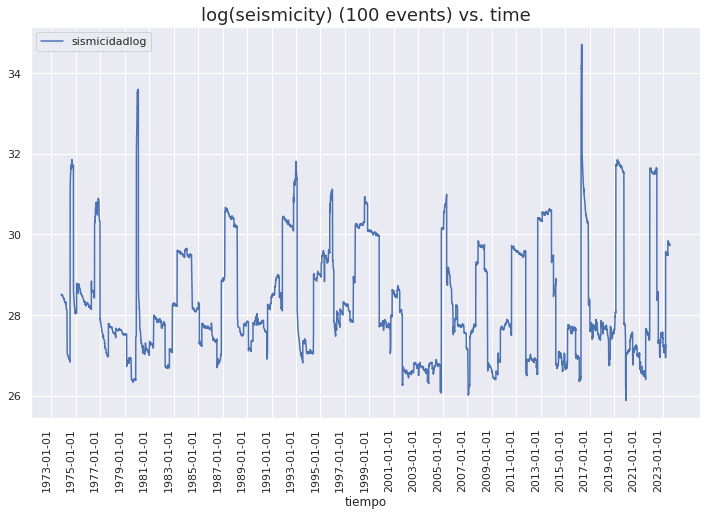

In [64]:
xticks = pd.date_range(datetime.datetime(1973,1,1), datetime.datetime(2023,10,1), freq='2YS')
for nev in [10,50,100]:
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca()
    dfvecresultados[dfvecresultados["neventos"]==nev].plot(x="tiempo",y="dtdias",figsize=(12,8),rot=90,xticks=xticks)
    plt.title("Day lapse for seismicity ("+str(nev)+" events) vs. time",fontsize=18)
    plt.savefig("dtdias-events-"+str(nev)+".png")

    fig = plt.figure(figsize=(12,8))
    ax = fig.gca()
    dfvecresultados[dfvecresultados["neventos"]==nev].plot(x="tiempo",y="sismicidadlog",figsize=(12,8),rot=90,xticks=xticks)
    plt.title("log(seismicity) ("+str(nev)+" events) vs. time",fontsize=18)
    plt.savefig("sismicidadlog-events-"+str(nev)+".png")
    


#catalogo.plot(x="time",y="energia",title="Earthquake Energy vs. time",figsize=(12,8),rot=90,xticks=xticks)

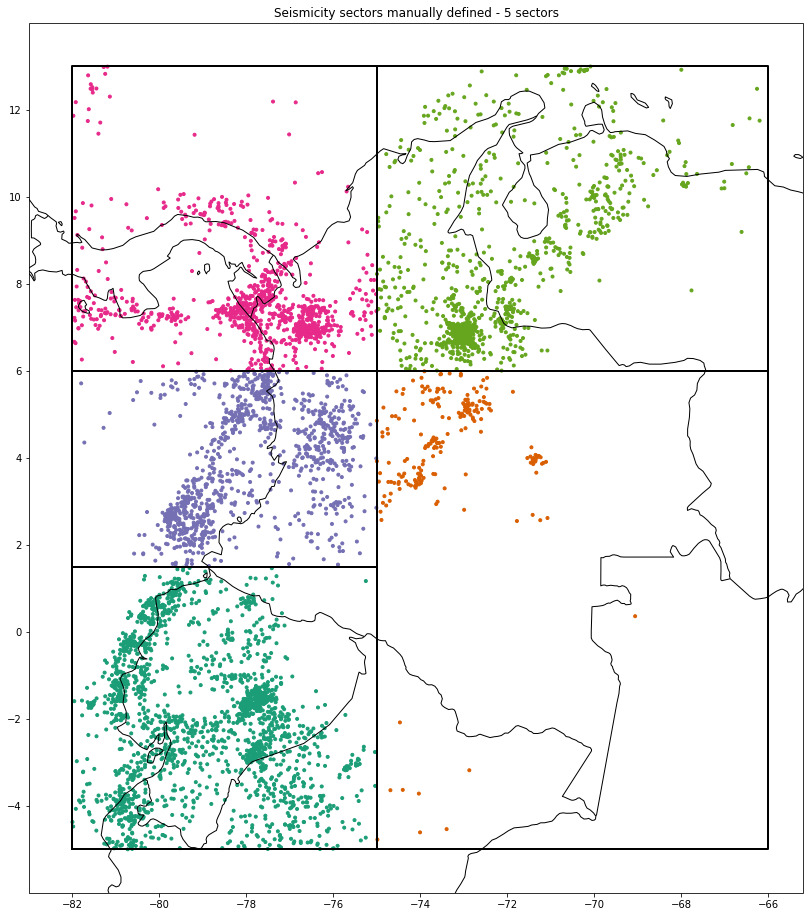

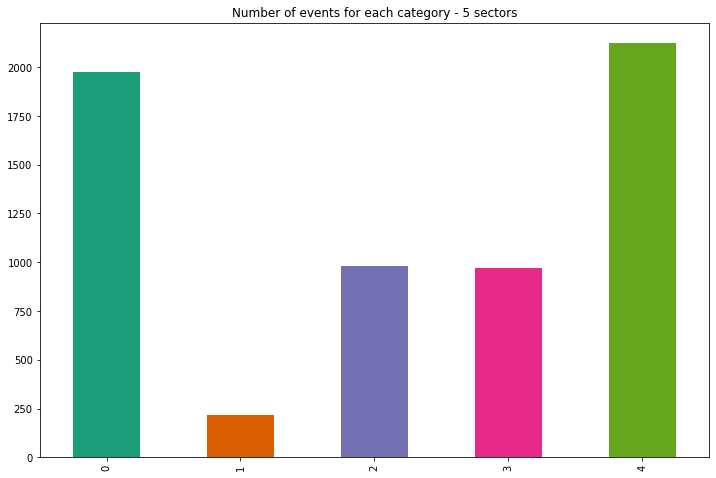

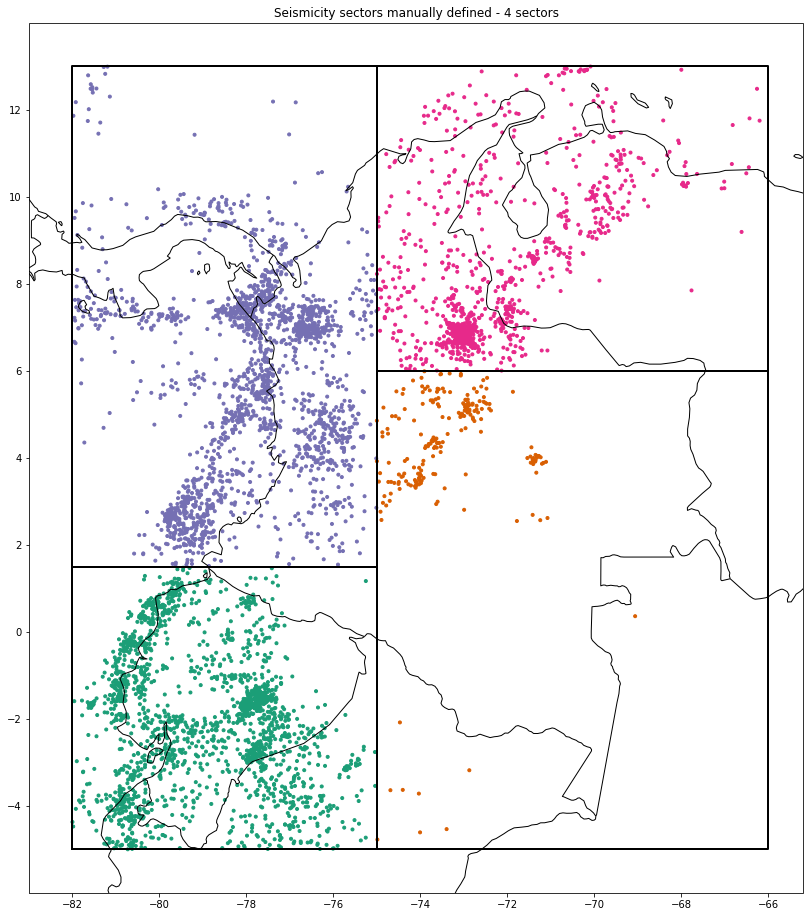

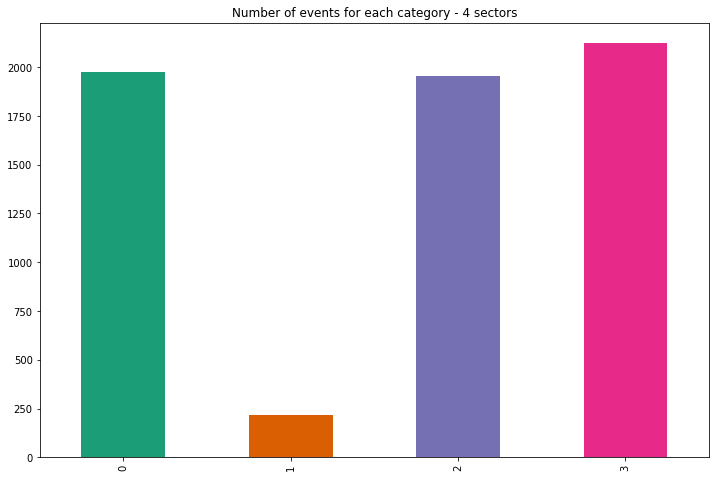

In [7]:
ltmin=-5
lnmin=-82
ltmax=13
lnmax=-66

dsectores=[{"sectores":[[ltmin,1.5,lnmin,-75],
          [ltmin,6,-75,lnmax],
          [1.5,6,lnmin,-75],
          [6,ltmax,lnmin,-75],
          [6,ltmax,-75,lnmax]],"nsectores":5},{"sectores":[[ltmin,1.5,lnmin,-75],
          [ltmin,6,-75,lnmax],
          [1.5,ltmax,lnmin,-75],
          [6,ltmax,-75,lnmax]]
,"nsectores":4}]

for ds in dsectores:
    sectores=ds["sectores"]
    nsectores=ds["nsectores"]
    nclases=len(sectores)
    labelcol=[]
    for i, row in catalogo.iterrows():
        lat=row.latitude
        lon=row.longitude
        label=-1
        for c in range(nclases):
            if lat>=sectores[c][0] and lat<sectores[c][1] and lon>=sectores[c][2] and lon<sectores[c][3]:
                label=c

        labelcol.append(label)

        
    catalogo["label"+str(nsectores)]=labelcol
    
    fig = plt.figure(figsize=(24,16))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    region=[min(catalogo["longitude"])-1, max(catalogo["longitude"])+1, min(catalogo["latitude"])-1, max(catalogo["latitude"])+1]
    ax.set_extent(region, crs=ccrs.PlateCarree())

    # Add our states feature.
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)

    #levels=[i for i in range(len(mpl.cm.Dark2.colors))]

    sc = ax.scatter(catalogo["longitude"],catalogo["latitude"],s=9,c=catalogo["label"+str(nsectores)],cmap='Dark2',vmin=0, vmax=8)

    ax.set_xticks([i for i in range(-82,-65,2)])#, crs=ccrs.PlateCarree())
    ax.set_yticks([i for i in range(-4,13,2)])#, crs=ccrs.PlateCarree())

    plt.title("Seismicity sectors manually defined - "+str(nclases)+" sectors")

    for c in sectores:
        plt.plot([c[2],c[2],c[3],c[3],c[2]],[c[0],c[1],c[1],c[0],c[0]],color='black',linewidth=2)
    #for i in range(lenlat-2):
    #    x=umbraleslat[i+1]
    #    plt.plot([lnmin,lnmax],[x,x],color='black',linewidth=2)
    #for i in range(nrows-1):
    #    x=ltmin+(drow*(i+1))

    plt.show()

    my_cmap = plt.get_cmap("Dark2")
    catalogo["label"+str(nsectores)].value_counts().sort_index().plot(kind='bar',figsize=(12,8),title="Number of events for each category - "+str(nsectores)+" sectors",color=my_cmap.colors)
    

# Redes de sismos para encontrar tamaño adecuado.

In [16]:
%%time

import networkx as nx

def calculaceldaprof(ltmin,lnmin,tmcel,gr2km,ancho,largo,lat,lon,prof):
    idx=ancho/tmcel
    i=int((lat-ltmin)*gr2km/tmcel)
    j=i*idx
    k=int((lon-lnmin)*gr2km/tmcel)
    #ki=int(i+j+1)
    ki=int(k+j+1)
    
    idp=int(prof/tmcel)
    idy=largo/tmcel
    idxy=idy*idx + 2
    #fidp=int(idp*idp)
    fidp=int(idxy*idxy)*idp

    return ki + fidp

def disprobgrado(grafo):
    m=nx.adjacency_matrix(grafo)
    v=[0 for i in range (m.shape[0])]
    v1=[0 for i in range (m.shape[0])]
    for i in range (m.shape[1]):
        i1=m[i].todense().sum()
        v[i1-1]=v[i1-1]+1
    tod=sum(v)
    for i in range(m.shape[1]):
        v1[i]=v[i]/tod
    return v1

def myExpFunc(x, a, b):
    return a * np.power(x, b)

def disestas(p1,p2):
    e1=dentropy([(p1[i]+p2[i])/2 for i in range(len(p1))])
    e2=(dentropy(p1)+dentropy(p2))/2
    return e1-e2

def dentropy(v):
    v1=[i*math.log(i) for i in list(filter(lambda x: x>0, v))]
    s1=-sum(v1)/math.log(len(v)-1)
    return s1

def smallworldness(g):
    n=nx.number_of_nodes(g)
    gp=gradprom(g)
    c=nx.average_clustering(g)
    p=nx.average_shortest_path_length(g)
    sw=c*n*np.log(n)/(p*gp*np.log(gp))
    return sw


#tamaños de celda
tamcel=[r for r in range(10,122,2)]

ltmin=-5
lnmin=-82
ltmax=13
lnmax=-66

gr2km=111

largo=((((ltmax-ltmin)*gr2km)//100)+(1 if ((ltmax-ltmin)*gr2km)%100 > 1 else 0))*100
ancho=((((lnmax-lnmin)*gr2km)//100)+(1 if ((lnmax-lnmin)*gr2km)%100 > 1 else 0))*100


#CALCULO DE GRAFOS
grafos=[]
disprobs=[]
gammas=[]

limsup=80
liminf=6

for tcel in tamcel:
    cp=[]
    for i, lin in catalogo.iterrows():
        cp.append(calculaceldaprof(ltmin,lnmin,tcel,gr2km,ancho,largo,lin["latitude"],lin["longitude"],lin["depth"]))

    grafoprof=nx.Graph()
    tam=len(cp)
    for j in range(1,tam):
        grafoprof.add_edge(cp[j-1],cp[j])

    catalogo.insert(len(catalogo.columns),"celda"+str(tcel),cp)
    grafos.append(grafoprof)
    d=disprobgrado(grafoprof)
    x=[i+liminf+1 for i in range(limsup)]
    y=[d[i+liminf] for i in range(limsup)]
    popt, pcov = curve_fit(myExpFunc, x, y)
    gammas.append([tcel,popt[1],limsup,liminf])

    disprobs.append(d)

dfgammas=pd.DataFrame(gammas,columns=["tcel","gamma","limsup","liminf"])

print("se tiene catalogo completo con identificacion de celdas")



se tiene catalogo completo con identificacion de celdas
CPU times: user 30 s, sys: 249 ms, total: 30.2 s
Wall time: 31.3 s


Se generan datos de redes de sismos. Corridas largas.

In [56]:
%%time

######################## SE DEMORA mas de media hora ############################

losdatos=[]

for itcel in range(len(tamcel)):
    tcel=tamcel[itcel]
    grafoprof=grafos[itcel]

    print(tcel)

    tam=len(catalogo["celda"+str(tcel)])
    
    #clusterings
    clustprof=nx.average_clustering(grafoprof)
            
    #average path length
    pathsprof=nx.average_shortest_path_length(grafoprof)
            
    #numero de bordes
    nedgesprof=grafoprof.number_of_edges()
            
    #numero de nodos
    nodosprof=nx.number_of_nodes(grafoprof)
            
    #Grado promedio
    gradsprof=gradprom( grafoprof )
            
    #distribucion de grado
    prgradprof=disprobgrado(grafoprof)
            
    #Entropia
    entprof=dentropy(prgradprof)
            
    #Smallworldness
    smallworldprof=smallworldness(grafoprof)
            
    #betweenness centrality
    betweenprof=list(nx.betweenness_centrality(grafoprof).values())

    #energia
    energia=sum(catalogo["energia"])
    losdatos.append([tcel,nodosprof,nedgesprof,gradsprof,clustprof,pathsprof,entprof,smallworldprof,betweenprof,prgradprof,energia])

dfdatosprof=pd.DataFrame(losdatos,columns=["tcel","nodos","edges","grado","cluster","path","entropia","smallworld","betweeness","disgrado","energia"])

dfdatosprof["gamma"]=dfgammas["gamma"]

nbetween=[]
for d in dfdatosprof["betweeness"]:
    #d1=d.strip("[]")
    #d2=d1.split(",")
    #d3=[float(d4) for d4 in d2]
    d3=[float(d4) for d4 in d]

    nbetween.append(np.mean(d3))
dfdatosprof["meanbetween"]=nbetween
dfdatosprof=dfdatosprof.drop(["betweeness"],axis=1);

dfdatosprof.to_csv("datos-redes-profundidad-catalogocompleto-new.csv")

dftcels=[pd.pivot_table(catalogo,values="energia",index=["celda"+str(t)],aggfunc={'energia':[np.mean,np.sum,np.median,stats.mode,'count']}) for t in tamcel]

nevs=len(catalogo)
#salida=[]
for i in range(len(grafos)):
    t=tamcel[i]
    print("inicia grafo",t)
    g=grafos[i]
    ns=list(g.nodes)
    bc=nx.betweenness_centrality(g)
    l=len(dftcels[i])
    dftcels[i]["latitude"]=np.zeros(l)
    dftcels[i]["longitude"]=np.zeros(l)
    dftcels[i]["depth"]=np.zeros(l)
    dftcels[i]["degree"]=np.zeros(l)
    dftcels[i]["clustering"]=np.zeros(l)
    dftcels[i]["betweeness"]=np.zeros(l)
    dftcels[i]["eccentricity"]=np.zeros(l)
    dftcels[i]["nevents"]=np.zeros(l)
    
    for n in ns:
        lt=catalogo[catalogo["celda"+str(t)]==n].latitude.mean()
        ln=catalogo[catalogo["celda"+str(t)]==n].longitude.mean()
        dp=catalogo[catalogo["celda"+str(t)]==n].depth.mean()
        gr=nx.degree(g,n)
        cl=nx.clustering(g,n)
        b=bc[n]
        nevs=len(catalogo[catalogo["celda"+str(t)]==n])
        ec=nx.eccentricity(g,n)
        dftcels[i].loc[n, ["latitude","longitude","depth","degree","clustering","betweeness","eccentricity","nevents"]]=lt,ln,dp,gr,cl,b,ec,nevs
        #salida.append([i,t,lt,ln,dp,gr,cl,b,nevs,ec])
    print("termina grafo",t)

datcelsall=[]
for i in range(len(tamcel)):
    tam=tamcel[i]
    for ind, row in dftcels[i].iterrows():
        v=[]
        v.append(tam)
        v.append(ind)
        for colum in dftcels[i].columns:
            v.append(row[colum])
        datcelsall.append(v)

dftcelsall=pd.DataFrame(datcelsall,columns=["tcel","celda","count","mean","median","mode","sum","latitude","longitude","depth","degree","clustering","betweeness","eccentricity","nevents"])
dftcelsall.to_csv("datosceldasredessismos.csv")



Se cargan datos anteriormente generados

In [17]:
import json

dfdatosprof=pd.read_csv("https://raw.githubusercontent.com/daniel-leon/redessismos/main/datos-redes-profundidad-catalogocompleto-new.csv")
dftcelsall=pd.read_csv("https://raw.githubusercontent.com/daniel-leon/redessismos/main/datosceldasredessismos.csv")



In [18]:
distribuciones=[]
for d in dfdatosprof["disgrado"]:
    distribuciones.append(json.loads(d))

    
dfdatosprof["disgrado"]=distribuciones
dfdatosprof["prob"]=dfdatosprof["grado"]/dfdatosprof["nodos"]
dfdatosprof["inodos"]=1/dfdatosprof["nodos"]

dfdatosprof["promenergianodos"]=[dftcelsall[dftcelsall['tcel']==t]["mean"].mean() for t in tamcel]
dfdatosprof["sumenergianodos"]=[dftcelsall[dftcelsall['tcel']==t]["sum"].mean() for t in tamcel]
dfdatosprof["promeventosnodos"]=[dftcelsall[dftcelsall['tcel']==t]["nevents"].mean() for t in tamcel]
dfdatosprof["medianenergianodos"]=[dftcelsall[dftcelsall['tcel']==t]["median"].mean() for t in tamcel]


# Graficas

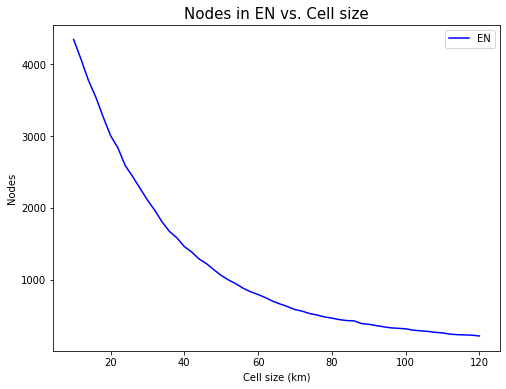

In [19]:
ax=dfdatosprof.plot(kind="line",x="tcel",y="nodos",color="blue",label="EN",figsize=(8,6))

ax.set_title("Nodes in EN vs. Cell size",fontsize=15)
ax.set_xlabel("Cell size (km)")
ax.set_ylabel("Nodes")
plt.savefig("nodosvscellsize.png")

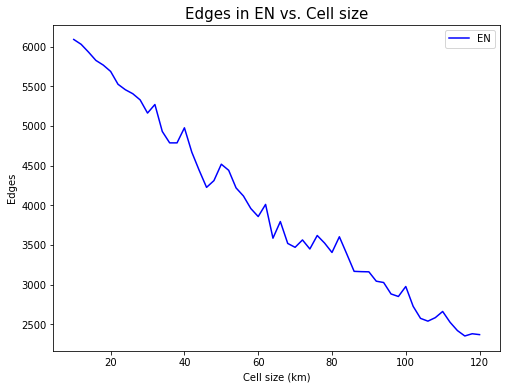

In [20]:
ax=dfdatosprof.plot(kind="line",x="tcel",y="edges",color="blue",label="EN",figsize=(8,6))

ax.set_title("Edges in EN vs. Cell size",fontsize=15)
ax.set_xlabel("Cell size (km)")
ax.set_ylabel("Edges")
plt.savefig("edgesvscellsize.png")

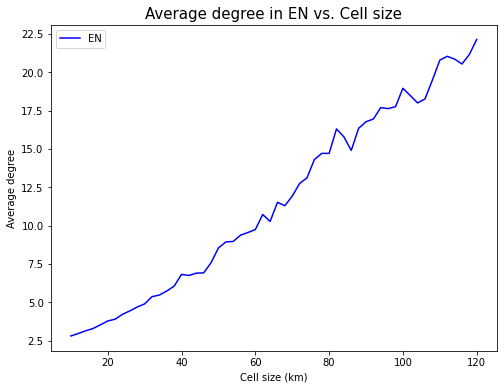

In [21]:
ax=dfdatosprof.plot(kind="line",x="tcel",y="grado",color="blue",label="EN",figsize=(8,6))

ax.set_title("Average degree in EN vs. Cell size",fontsize=15)
ax.set_xlabel("Cell size (km)")
ax.set_ylabel("Average degree")
plt.savefig("degreevscellsize.png")

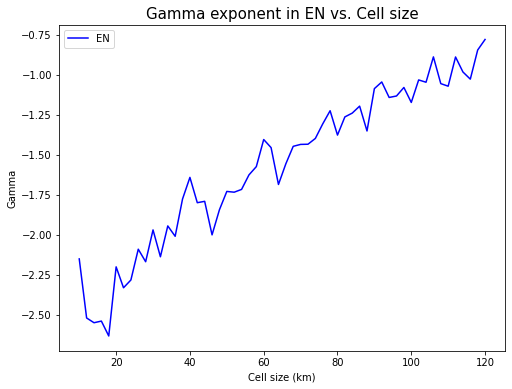

In [22]:
ax=dfdatosprof.plot(kind="line",x="tcel",y="gamma",color="blue",label="EN",figsize=(8,6))

ax.set_title("Gamma exponent in EN vs. Cell size",fontsize=15)
ax.set_xlabel("Cell size (km)")
ax.set_ylabel("Gamma")
plt.savefig("gammavscellsize.png")

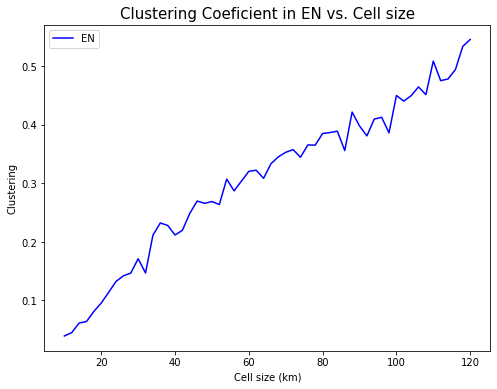

In [23]:
ax=dfdatosprof.plot(kind="line",x="tcel",y="cluster",color="blue",label="EN",figsize=(8,6))

ax.set_title("Clustering Coeficient in EN vs. Cell size",fontsize=15)
ax.set_xlabel("Cell size (km)")
ax.set_ylabel("Clustering")
plt.savefig("clustervscellsize.png")

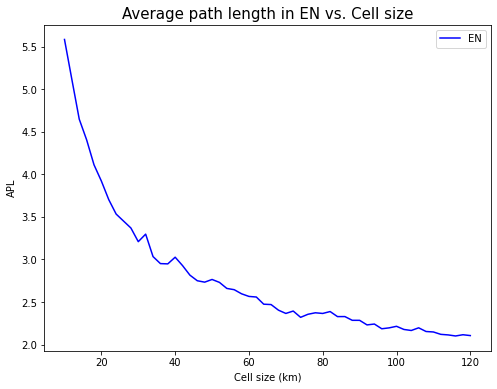

In [24]:
ax=dfdatosprof.plot(kind="line",x="tcel",y="path",color="blue",label="EN",figsize=(8,6))

ax.set_title("Average path length in EN vs. Cell size",fontsize=15)
ax.set_xlabel("Cell size (km)")
ax.set_ylabel("APL")
plt.savefig("aplvscellsize.png")

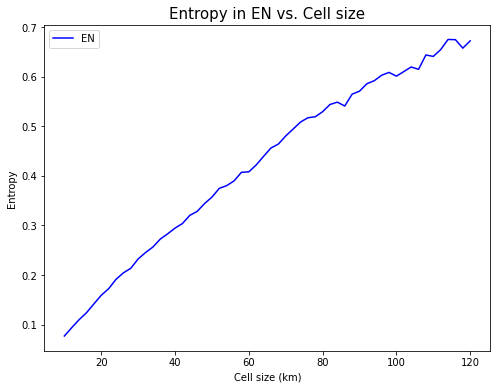

In [25]:
ax=dfdatosprof.plot(kind="line",x="tcel",y="entropia",color="blue",label="EN",figsize=(8,6))

ax.set_title("Entropy in EN vs. Cell size",fontsize=15)
ax.set_xlabel("Cell size (km)")
ax.set_ylabel("Entropy")
plt.savefig("entropyvscellsize.png")

In [29]:
dfdatosprof.columns

Index(['Unnamed: 0', 'tcel', 'nodos', 'edges', 'grado', 'cluster', 'path',
       'entropia', 'smallworld', 'disgrado', 'energia', 'gamma', 'meanbetween',
       'promenergianodos', 'sumenergianodos', 'promeventosnodos',
       'medianenergianodos', 'prob', 'inodos'],
      dtype='object')

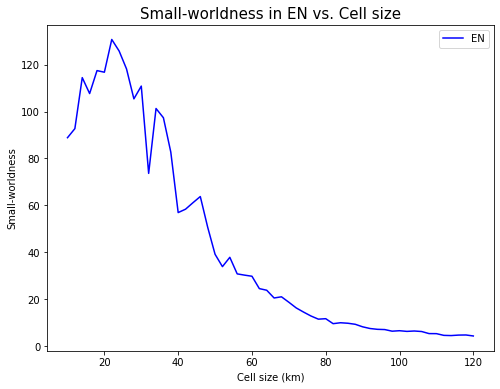

In [26]:
ax=dfdatosprof.plot(kind="line",x="tcel",y="smallworld",color="blue",label="EN",figsize=(8,6))

ax.set_title("Small-worldness in EN vs. Cell size",fontsize=15)
ax.set_xlabel("Cell size (km)")
ax.set_ylabel("Small-worldness")
plt.savefig("smallworldvscellsize.png")

# Simulaciones de redes

In [ ]:
%%time

#para calcular la divergencia Kullback-Leibler
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))
##################### DEMORA 9horas ##########################

nbetas=20
betas=[b for b in np.arange(0.1,1.01,0.1)]

#ntests=25

losdatos=[]
indices=dfdatosprof.tcel.values

for t in tamcel:
    nodos=dfdatosprof[dfdatosprof.tcel==t].nodos.values[0]
    grado=dfdatosprof[dfdatosprof.tcel==t].grado.values[0]
    smallworld=dfdatosprof[dfdatosprof.tcel==t].smallworld.values[0]
    ii=np.where(indices == t)[0][0]
    prgrado=disprobgrado(grafos[ii])
            
    for b in betas:
        
        g=[nx.connected_watts_strogatz_graph(nodos,int(round(grado)),b,400) for i in range(nbetas)]
        print(f"celda: {t} - nodos {nodos} grado {grado} beta {b}")

        sws=[smallworldness(g1) for g1 in g]
        losdatos.append([t,nodos,grado,smallworld,b,statistics.mean(sws),statistics.stdev(sws),min(sws),max(sws)])

dflosdatos=pd.DataFrame(losdatos,columns=["tamcel","nodos","grado","smallworldness","beta","mean-sw","stdev-sw","sw-min","sw-max"])
dflosdatos["swdiff"]=dflosdatos.apply(lambda row: row["smallworldness"] - row["mean-sw"], axis=1)
dflosdatos["absswdiff"]=dflosdatos["swdiff"].abs().to_list()
dflosdatos.to_csv("datos-smallworldness-red-completa-new.csv")

dft3=pd.DataFrame(columns=dflosdatos.columns)
dft4=pd.DataFrame(columns=dflosdatos.columns)
for t in tamcel:
    dft=dflosdatos[dflosdatos["tamcel"]==t]
    dft=dft[dft["absswdiff"]==dft["absswdiff"].max()]
    dft4=pd.concat([dft4,dft],ignore_index=True)
    dft=dflosdatos[dflosdatos["tamcel"]==t]
    dft=dft[dft["absswdiff"]==dft["absswdiff"].min()]
    dft3=pd.concat([dft3,dft],ignore_index=True)
dfwork=dft3
dfwork.to_csv("datos-redes-smallworldness-catalogo-completo-new.csv")

ntests=100

indices=dfdatosprof.tcel.values

divergenciaskl=[] #kullback-liebler
divergencias=[] #Shannon-Jensen

    
for index, linea in dfwork.iterrows():
    t=linea.tamcel
    print(f"inicia tamano {t}")
    nodos=linea.nodos
    grado=linea.grado

    cluster=dfdatosprof[dfdatosprof["tcel"]==t].cluster.values[0]
    path=dfdatosprof[dfdatosprof["tcel"]==t].path.values[0]
    entropia=dfdatosprof[dfdatosprof["tcel"]==t].entropia.values[0]
    between=dfdatosprof[dfdatosprof["tcel"]==t].meanbetween.values[0]
    
    prgrado=dfdatosprof[dfdatosprof["tcel"]==t].disgrado.values[0]
    
    beta=linea.beta
    # Se calculan redes aleatorias.
    print("inician tests")
    for i in range(ntests):
        rer1=nx.erdos_renyi_graph(nodos,grado/nodos)
        rer2=nx.erdos_renyi_graph(nodos,grado/nodos)
        rsw1=nx.connected_watts_strogatz_graph(nodos,int(round(grado)),beta,150)
        rsf=nx.barabasi_albert_graph(nodos,int(round(grado/2)))

        rer11=rer1.subgraph(max(nx.connected_components(rer1), key=len).copy())
        rer22=rer2.subgraph(max(nx.connected_components(rer2), key=len).copy())
        
        clsw=nx.average_clustering(rsw1)
        cler=nx.average_clustering(rer22)
        clsf=nx.average_clustering(rsf)

        psw=nx.average_shortest_path_length(rsw1)
        per=nx.average_shortest_path_length(rer22)
        psf=nx.average_shortest_path_length(rsf)

        er1=disprobgrado(rer1)
        er2=disprobgrado(rer2)
        
        sw1=disprobgrado(rsw1)
        sf=disprobgrado(rsf)

        entr2=dentropy(er2)
        entsw1=dentropy(sw1)
        entsf=dentropy(sf)
        
        b=list(nx.betweenness_centrality(rer2).values())
        betr2=np.mean(b)
        b=list(nx.betweenness_centrality(rsw1).values())
        betsw1=np.mean(b)
        b=list(nx.betweenness_centrality(rsf).values())
        betsf=np.mean(b)
        
        divssw=disestas(sw1,er1)
        divsswkl=KL(sw1,er1)

        divser=disestas(er2,er1)
        divserkl=KL(er2,er1)
        divssf=disestas(sf,er1)
        divssfkl=KL(sf,er1)
        divsen=disestas(prgrado,er1)
        divsenkl=KL(prgrado,er1)

        divensw1kl=KL(prgrado,sw1)
        divensfkl=KL(prgrado,sf)
        
        divergencias.append([t,grado,cluster,path,divsen,divsenkl,cler,per,divser,divserkl,clsw,psw,divssw,divsswkl,beta,clsf,psf,divssf,divssfkl,divensw1,divensw1kl,divensf,divensfkl,entropia,entr2,entsw1,entsf,between,betr2,betsw1,betsf])
        #divergencias.append([t,grado,cluster,path,divsen,cler,per,divser,clsw,psw,divssw,beta,clsf,psf,divssf,divensw1,divensf,entropia,entr2,entsw1,entsf,between,betr2,betsw1,betsf])
        divergenciaskl.append([t,divsenkl,divserkl,divsswkl,divssfkl,divensw1kl,divensfkl])
        
    print(f"listo tamano {t}")
dfdivergenciaskl=pd.DataFrame(divergenciaskl,columns=["tcel","DivENKL","DivERKL","DivSWKL","DivSFKL","DivENSWKL","DivENSFKL"])
    
dfdivergenciaskl.to_csv("divergenciaskl-catalogo-completo-new.csv")



Carga datos ya calculados antes

In [27]:
dflosdatos=pd.read_csv("https://raw.githubusercontent.com/daniel-leon/redessismos/main/datos-smallworldness-red-completa-new.csv")
dfdivergencias=pd.read_csv("https://raw.githubusercontent.com/daniel-leon/redessismos/main/divergencias-catalogo-completo-new.csv")
dfwork=pd.read_csv("https://raw.githubusercontent.com/daniel-leon/redessismos/main/datos-redes-smallworldness-catalogo-completo-new.csv")
dfdivergenciaskl=pd.read_csv("https://raw.githubusercontent.com/daniel-leon/redessismos/main/divergenciaskl-catalogo-completo-new.csv")

In [28]:
%%time
#esto demora menos de un segundo.

#Datos promedio de divergencias
out=[]
for t in range(10,121,2):
    dtemp=dfdivergencias[dfdivergencias.tcel == t]
    dtempkl=dfdivergenciaskl[dfdivergenciaskl.tcel == t]

    
    divenmean=dtemp.DivEN.mean()
    divenstd=dtemp.DivEN.std()
    divermean=dtemp.DivER.mean()
    diverstd=dtemp.DivER.std()
    divswmean=dtemp.DivSW.mean()
    divswstd=dtemp.DivSW.std()
    beta=dtemp.beta.mean()
    divsfmean=dtemp.DivSF.mean()
    divsfstd=dtemp.DivSF.std()

    divenswswmean=dtemp.DivENSWsw.mean()
    divenswswstd=dtemp.DivENSWsw.std()
    divensfmean=dtemp.DivENSF.mean()
    divensfstd=dtemp.DivENSF.std()

    divenklmean=dtempkl.DivENKL.mean()
    divenklstd=dtempkl.DivENKL.std()
    diverklmean=dtempkl.DivERKL.mean()
    diverklstd=dtempkl.DivERKL.std()
    divswklmean=dtempkl.DivSWKL.mean()
    divswklstd=dtempkl.DivSWKL.std()
    divsfklmean=dtempkl.DivSFKL.mean()
    divsfklstd=dtempkl.DivSFKL.std()

    divenswklmean=dtempkl.DivENSWKL.mean()
    divenswklstd=dtempkl.DivENSWKL.std()
    divensfklmean=dtempkl.DivENSFKL.mean()
    divensfklstd=dtempkl.DivENSFKL.std()

    
    ent=dtemp.entropia.mean()
    entrnmean=dtemp.entrn.mean()
    entrnstd=dtemp.entrn.std()
    entswswmean=dtemp.entsw1.mean()
    entswswstd=dtemp.entsw1.std()
    entsfmean=dtemp.entsf.mean()
    entsfstd=dtemp.entsf.std()

    bet=dtemp.betweeness.mean()
    betrnmean=dtemp.betr2.mean()
    betrnstd=dtemp.betr2.std()
    betswswmean=dtemp.betsw1.mean()
    betswswstd=dtemp.betsw1.std()
    betsfmean=dtemp.betsf.mean()
    betsfstd=dtemp.betsf.std()

    cluster=dtemp.cluster.mean()
    cluermean=dtemp.cler.mean()
    cluerstd=dtemp.cler.std()
    cluswmean=dtemp.clsw.mean()
    cluswstd=dtemp.clsw.std()
    clusfmean=dtemp.clsf.mean()
    clusfstd=dtemp.clsf.std()
    
    path=dtemp.path.mean()
    patermean=dtemp.per.mean()
    paterstd=dtemp.per.std()
    patswmean=dtemp.psw.mean()
    patswstd=dtemp.psw.std()
    patsfmean=dtemp.psf.mean()
    patsfstd=dtemp.psf.std()


    out.append([t,divenmean,divenstd,
                divermean,diverstd,divswmean,divswstd,beta,divsfmean,divsfstd,
                divenswswmean,divenswswstd,divensfmean,divensfstd,
                ent,entrnmean,entrnstd,entswswmean,entswswstd,entsfmean,entsfstd,
                bet,betrnmean,betrnstd,betswswmean,betswswstd,betsfmean,betsfstd,
                cluster,cluermean,cluerstd,cluswmean,cluswstd,clusfmean,clusfstd,
                path,patermean,paterstd,patswmean,patswstd,patsfmean,patsfstd,
                divenklmean,diverklmean,divswklmean,divsfklmean,divenswklmean,divensfklmean])
dfmeandivergencias=pd.DataFrame(out,columns=["tcel","divENmean","divENstd",
                                            "divERmean","divERstd","divSWmean","divSWstd","beta","divSFmean","divSFstd",
                                            "divENSWswmean","divENSWswstd","divENSFmean","divENSFstd",
                                            "ent","entERmean","entERstd","entSWswmean","entSWswstd","entSFmean","entSFstd",
                                            "bet","betERmean","betERstd","betSWswmean","betSWswstd","betSFmean","betSFstd",
                                            "cluster","cluERmean","cluERstd","cluSWswmean","cluSWswstd","cluSFmean","cluSFstd",
                                            "path","patERmean","patERstd","patSWswmean","patSWswstd","patSFmean","patSFstd",
                                            "divENkl","divERkl","divSWkl","divSFkl","divENSWkl","divENSFkl"])

dfmeandivergencias["complejidad"]=dfmeandivergencias["divENmean"]*dfmeandivergencias.ent
dfmeandivergencias["compER"]=dfmeandivergencias["divERmean"]*dfmeandivergencias["entERmean"]
dfmeandivergencias["compSWsw"]=dfmeandivergencias["divSWmean"]*dfmeandivergencias["entSWswmean"]
dfmeandivergencias["compSF"]=dfmeandivergencias["divSFmean"]*dfmeandivergencias["entSFmean"]

dfmeandivergencias["complejidadkl"]=dfmeandivergencias["divENkl"]*dfmeandivergencias.ent
dfmeandivergencias["compERkl"]=dfmeandivergencias["divERkl"]*dfmeandivergencias["entERmean"]
dfmeandivergencias["compSWkl"]=dfmeandivergencias["divSWkl"]*dfmeandivergencias["entSWswmean"]
dfmeandivergencias["compSFkl"]=dfmeandivergencias["divSFkl"]*dfmeandivergencias["entSFmean"]

dfmeandivergencias["difEN-ER"]=dfmeandivergencias["divENmean"]-dfmeandivergencias["divERmean"]
dfmeandivergencias["difEN-SW"]=dfmeandivergencias["divENmean"]-dfmeandivergencias["divSWmean"]
dfmeandivergencias["difEN-SF"]=dfmeandivergencias["divENmean"]-dfmeandivergencias["divSFmean"]

dfmeandivergencias["difENkl-ERkl"]=dfmeandivergencias["divENkl"]-dfmeandivergencias["divERkl"]
dfmeandivergencias["difENkl-SWkl"]=dfmeandivergencias["divENkl"]-dfmeandivergencias["divSWkl"]
dfmeandivergencias["difENkl-SFkl"]=dfmeandivergencias["divENkl"]-dfmeandivergencias["divSFkl"]


dfmeandivergencias.to_csv("dfmeandivergencias-new.csv")

dfmeandiferencias=dfmeandivergencias[["tcel","difEN-ER","difEN-SW","difEN-SF","difENkl-ERkl","difENkl-SWkl","difENkl-SFkl"]]

CPU times: user 522 ms, sys: 0 ns, total: 522 ms
Wall time: 547 ms


# Graficas

In [35]:
dfmeandivergencias.columns

Index(['tcel', 'divENmean', 'divENstd', 'divERmean', 'divERstd', 'divSWmean',
       'divSWstd', 'beta', 'divSFmean', 'divSFstd', 'divENSWswmean',
       'divENSWswstd', 'divENSFmean', 'divENSFstd', 'ent', 'entERmean',
       'entERstd', 'entSWswmean', 'entSWswstd', 'entSFmean', 'entSFstd', 'bet',
       'betERmean', 'betERstd', 'betSWswmean', 'betSWswstd', 'betSFmean',
       'betSFstd', 'cluster', 'cluERmean', 'cluERstd', 'cluSWswmean',
       'cluSWswstd', 'cluSFmean', 'cluSFstd', 'path', 'patERmean', 'patERstd',
       'patSWswmean', 'patSWswstd', 'patSFmean', 'patSFstd', 'divENkl',
       'divERkl', 'divSWkl', 'divSFkl', 'divENSWkl', 'divENSFkl',
       'complejidad', 'compER', 'compSWsw', 'compSF', 'complejidadkl',
       'compERkl', 'compSWkl', 'compSFkl', 'difEN-ER', 'difEN-SW', 'difEN-SF',
       'difENkl-ERkl', 'difENkl-SWkl', 'difENkl-SFkl'],
      dtype='object')

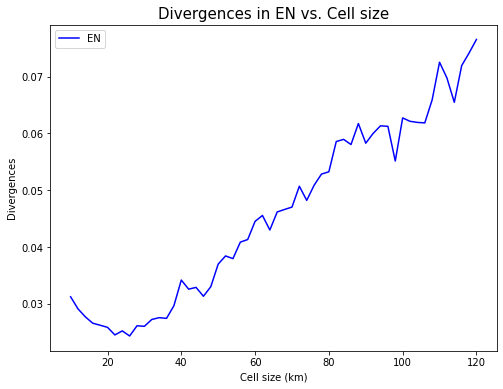

In [29]:
ax=dfmeandivergencias.plot(kind="line",x="tcel",y="divENmean",color="blue",label="EN",figsize=(8,6))

ax.set_title("Divergences in EN vs. Cell size",fontsize=15)
ax.set_xlabel("Cell size (km)")
ax.set_ylabel("Divergences")
plt.savefig("divergenciasvscellsie.png")

Text(0, 0.5, 'Beta')

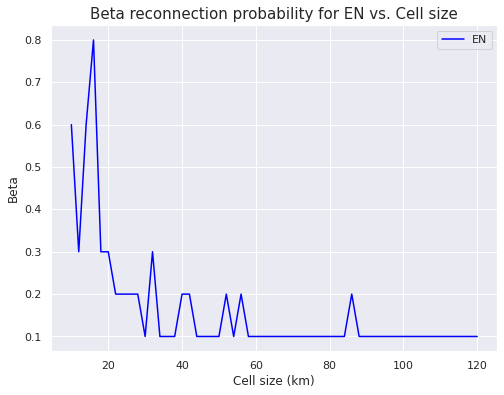

In [60]:
ax=dfmeandivergencias.plot(kind="line",x="tcel",y="beta",color="blue",label="EN",figsize=(8,6))

ax.set_title("Beta reconnection probability for EN vs. Cell size",fontsize=15)
ax.set_xlabel("Cell size (km)")
ax.set_ylabel("Beta")
#plt.savefig("divergenciasvscellsie.png")

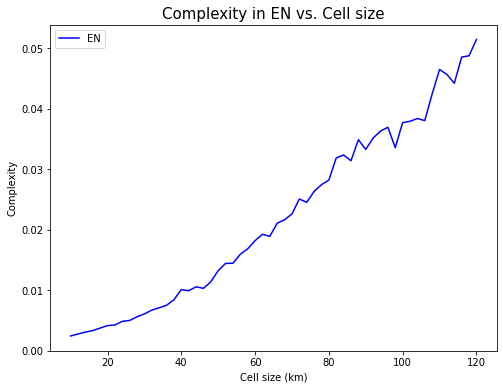

In [30]:
ax=dfmeandivergencias.plot(kind="line",x="tcel",y="complejidad",color="blue",label="EN",figsize=(8,6))

ax.set_title("Complexity in EN vs. Cell size",fontsize=15)
ax.set_xlabel("Cell size (km)")
ax.set_ylabel("Complexity")
plt.savefig("complexityvscellsize.png")

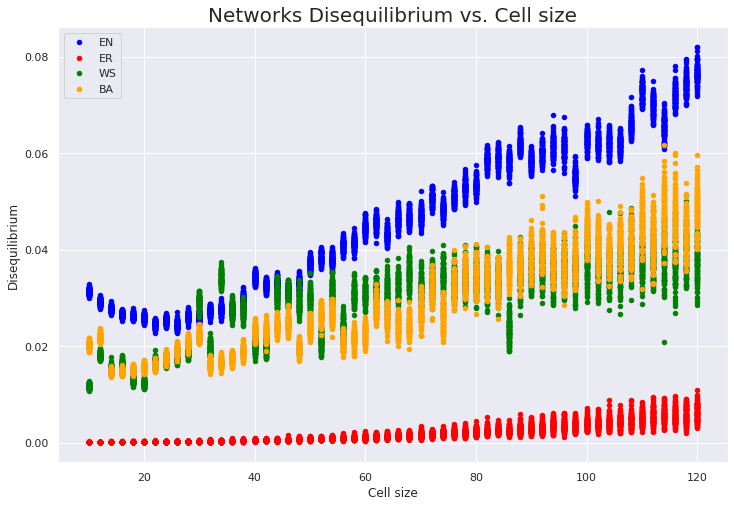

In [62]:
import seaborn as sns
sns.set(rc={"figure.figsize":(12, 8)}) #width=8, height=4

ax=dfdivergencias.plot(kind="scatter",x="tcel",y="DivEN",color="blue",label="EN")
dfdivergencias.plot(kind="scatter",x="tcel",y="DivER",color="red",label="ER",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="DivSW",color="green",label="WS",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="DivSF",color="orange",label="BA",ax=ax)


ax.set_title("Networks Disequilibrium vs. Cell size",fontsize=20)
ax.set_ylabel("Disequilibrium")
ax.set_xlabel("Cell size")
plt.savefig("disequilibriumsvscellsize")

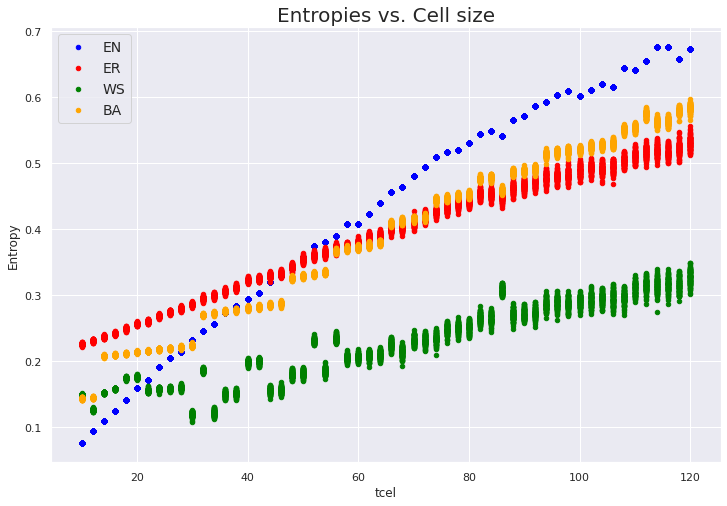

In [63]:
import seaborn as sns
sns.set(rc={"figure.figsize":(12, 8)}) #width=8, height=4

ax=dfdivergencias.plot(kind="scatter",x="tcel",y="entropia",color="blue",label="EN")
dfdivergencias.plot(kind="scatter",x="tcel",y="entrn",color="red",label="ER",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="entsw1",color="green",label="WS",ax=ax)

dfdivergencias.plot(kind="scatter",x="tcel",y="entsf",color="orange",label="BA",ax=ax)

ax.set_title("Entropies vs. Cell size",fontsize=20)
ax.set_ylabel("Entropy")
plt.legend(fontsize=14)
plt.savefig("entropiasenerwsbavscellsize.png")

Text(0.5, 0, 'Tamaño de celda')

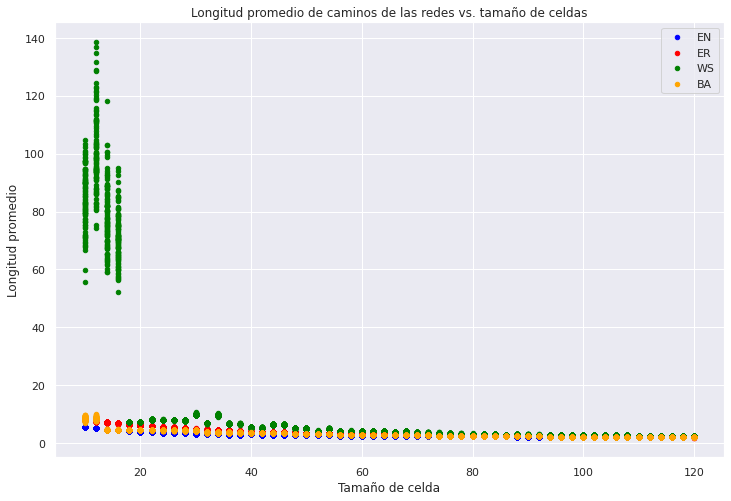

In [84]:
sns.set(rc={"figure.figsize":(12, 8)}) #width=8, height=4

ax=dfdivergencias.plot(kind="scatter",x="tcel",y="path",color="blue",label="EN")
dfdivergencias.plot(kind="scatter",x="tcel",y="per",color="red",label="ER",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="psw",color="green",label="WS",ax=ax)

dfdivergencias.plot(kind="scatter",x="tcel",y="psf",color="orange",label="BA",ax=ax)

ax.set_title("Longitud promedio de caminos de las redes vs. tamaño de celdas")
ax.set_ylabel("Longitud promedio")
ax.set_xlabel("Tamaño de celda")


Text(0.5, 0, 'Tamaño de celda')

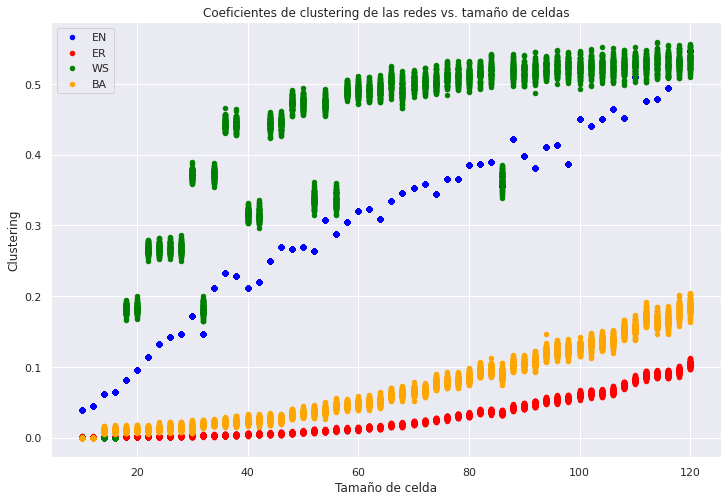

In [85]:
sns.set(rc={"figure.figsize":(12, 8)}) #width=8, height=4

ax=dfdivergencias.plot(kind="scatter",x="tcel",y="cluster",color="blue",label="EN")
dfdivergencias.plot(kind="scatter",x="tcel",y="cler",color="red",label="ER",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="clsw",color="green",label="WS",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="clsf",color="orange",label="BA",ax=ax)

ax.set_title("Coeficientes de clustering de las redes vs. tamaño de celdas")
ax.set_ylabel("Clustering")
ax.set_xlabel("Tamaño de celda")


In [13]:
dfdivergencias["complejidad"]=dfdivergencias["DivEN"]*dfdivergencias["entropia"]
dfdivergencias["comper"]=dfdivergencias["DivER"]*dfdivergencias["entrn"]
dfdivergencias["compsw1"]=dfdivergencias["DivSW"]*dfdivergencias["entsw1"]
dfdivergencias["compsf"]=dfdivergencias["DivSF"]*dfdivergencias["entsf"]

Text(0.5, 0, 'Tamaño de celda')

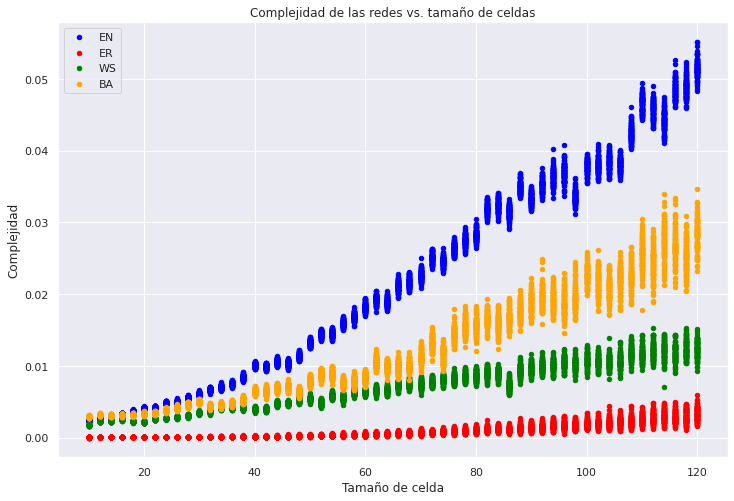

In [87]:
sns.set(rc={"figure.figsize":(12, 8)}) #width=8, height=4

ax=dfdivergencias.plot(kind="scatter",x="tcel",y="complejidad",color="blue",label="EN")
dfdivergencias.plot(kind="scatter",x="tcel",y="comper",color="red",label="ER",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="compsw1",color="green",label="WS",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="compsf",color="orange",label="BA",ax=ax)

ax.set_title("Complejidad de las redes vs. tamaño de celdas")
ax.set_ylabel("Complejidad")
ax.set_xlabel("Tamaño de celda")


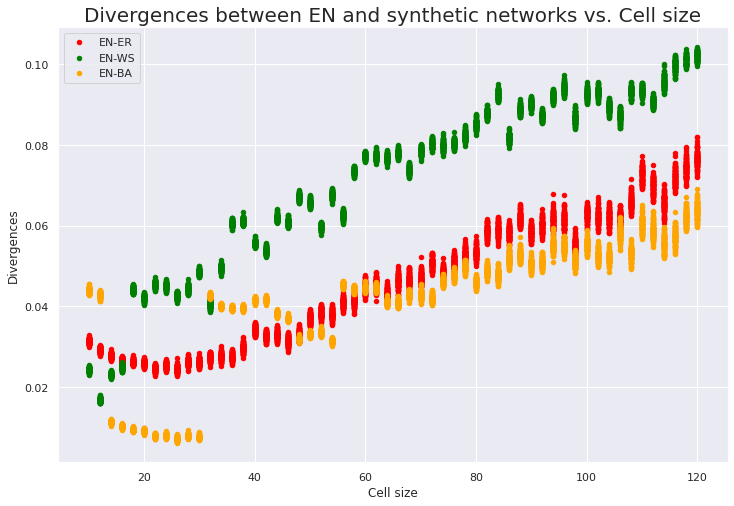

In [61]:
sns.set(rc={"figure.figsize":(12, 8)}) #width=8, height=4

ax=dfdivergencias.plot(kind="scatter",x="tcel",y="DivEN",color="red",label="EN-ER")
dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSWsw",color="green",label="EN-WS",ax=ax)
dfdivergencias.plot(kind="scatter",x="tcel",y="DivENSF",color="orange",label="EN-BA",ax=ax)


#ax.set_title("Divergencias entre las redes de sismos y las redes sintéticas vs. tamaño de celdas")
ax.set_title("Divergences between EN and synthetic networks vs. Cell size",fontsize=20)
ax.set_ylabel("Divergences")
ax.set_xlabel("Cell size")
plt.savefig("divergencias-erwsba-cellsize.png")



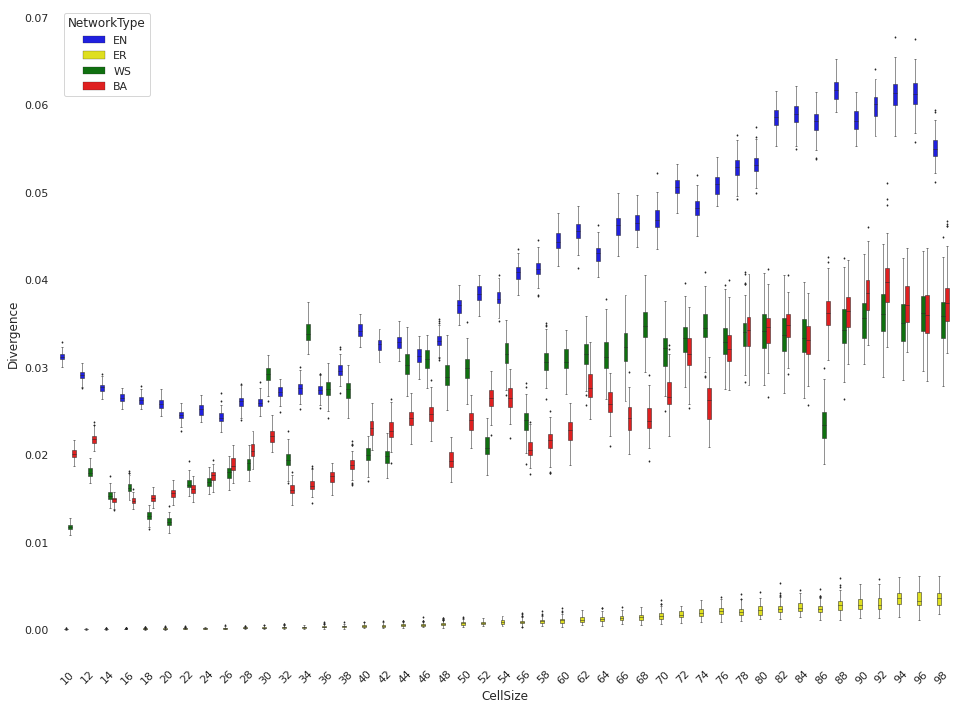

In [89]:
#Grafica de boxplots para las divergencias

## DIVERGENCIAS ##
dfdiv1=dfdivergencias[["DivEN","tcel"]].assign(divergencia="EN")
dfdiv2=dfdivergencias[["DivER","tcel"]].assign(divergencia="ER")
dfdiv3=dfdivergencias[["DivSW","tcel"]].assign(divergencia="WS")
#dfdiv5=dfdivergencias[["DivSWdiv","tcel"]].assign(divergencia="SWdiv")
dfdiv4=dfdivergencias[["DivSF","tcel"]].assign(divergencia="BA")
columnas=["Divergence","CellSize","NetworkType"]
#dfdiv1.columns=["value","tcel","divergencia"]
dfdiv1.columns=columnas
dfdiv2.columns=columnas
dfdiv3.columns=columnas
dfdiv4.columns=columnas
#dfdiv5.columns=columnas
dfdivs = pd.concat([dfdiv1, dfdiv2, dfdiv3, dfdiv4])                                # CONCATENATE

#ax = sns.boxplot(x="tcel", y="value", hue="divergencia", data=dfdivs[dfdivs["tcel"]<100])  # RUN PLOT
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', "figure.figsize":(16, 12)})
#sns.set(rc={"figure.figsize":(16, 10)})

colores = {'EN': 'blue', 'ER': 'yellow', 'WS': 'green', 'BA': 'red'}

#sns.boxplot(x='group_var', y='values_var', data=df, palette=my_colors)

ax = sns.boxplot(x=columnas[1], y=columnas[0], hue=columnas[2], palette=colores, data=dfdivs[dfdivs[columnas[1]]<100], linewidth=0.5, fliersize=1)  # RUN PLOT
plt.xticks(rotation=45);
plt.show()

plt.clf()
plt.close()

Text(0, 0.5, 'div.')

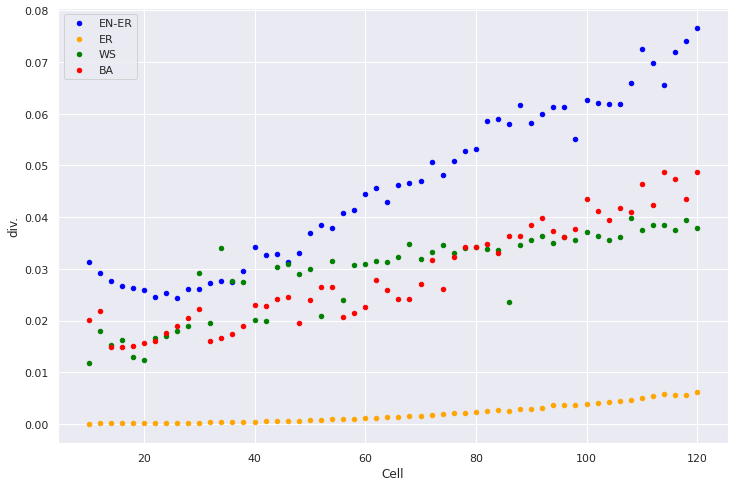

In [91]:
#grafico de promedios de divergencias
sns.set(rc={"figure.figsize":(12, 8)}) #width=8, height=4

ax1=dfmeandivergencias.plot(kind='scatter', x="tcel", y="divENmean", color='blue', label="EN-ER")
ax2=dfmeandivergencias.plot(kind='scatter', x="tcel", y="divERmean", color='orange', label="ER", ax=ax1)
ax3=dfmeandivergencias.plot(kind='scatter', x="tcel", y="divSWmean", color='green', label="WS", ax=ax1)
ax4=dfmeandivergencias.plot(kind='scatter', x="tcel", y="divSFmean", color='red', label="BA", ax=ax1)

ax1.set_xlabel('Cell')
ax1.set_ylabel('div.')


<AxesSubplot:xlabel='tcel'>

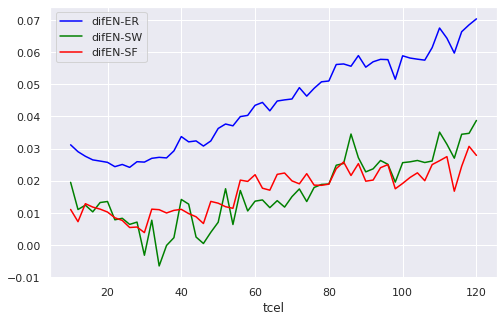

In [92]:
sns.set(rc={"figure.figsize":(8, 5)}) #width=8, height=4

dfmeandivergencias.plot(x='tcel',y=["difEN-ER","difEN-SW","difEN-SF"],subplots=False, color=["blue","green","red"])

Text(0, 0.5, 'cluster.')

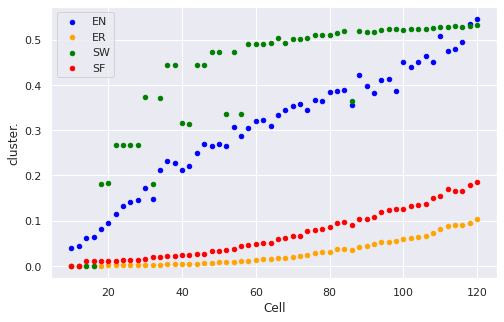

In [93]:
sns.set(rc={"figure.figsize":(8, 5)}) #width=8, height=4

ax1=dfmeandivergencias.plot(kind='scatter', x="tcel", y="cluster", color='blue', label="EN")
ax2=dfmeandivergencias.plot(kind='scatter', x="tcel", y="cluERmean", color='orange', label="ER", ax=ax1)
ax3=dfmeandivergencias.plot(kind='scatter', x="tcel", y="cluSWswmean", color='green', label="SW", ax=ax1)
ax4=dfmeandivergencias.plot(kind='scatter', x="tcel", y="cluSFmean", color='red', label="SF", ax=ax1)

ax1.set_xlabel('Cell')
ax1.set_ylabel('cluster.')



Text(0, 0.5, 'path.')

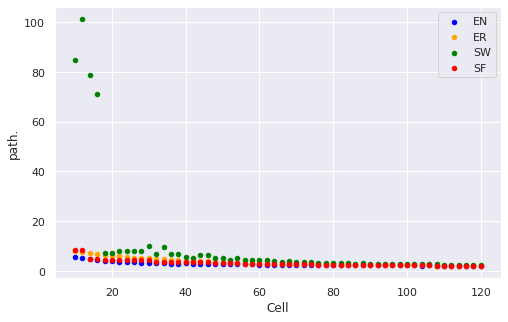

In [94]:
#grafico de promedios de paths
sns.set(rc={"figure.figsize":(8, 5)}) #width=8, height=4

ax1=dfmeandivergencias.plot(kind='scatter', x="tcel", y="path", color='blue', label="EN")
ax2=dfmeandivergencias.plot(kind='scatter', x="tcel", y="patERmean", color='orange', label="ER", ax=ax1)
ax3=dfmeandivergencias.plot(kind='scatter', x="tcel", y="patSWswmean", color='green', label="SW", ax=ax1)
ax4=dfmeandivergencias.plot(kind='scatter', x="tcel", y="patSFmean", color='red', label="SF", ax=ax1)

ax1.set_xlabel('Cell')
ax1.set_ylabel('path.')


Text(0, 0.5, 'Betweeness.')

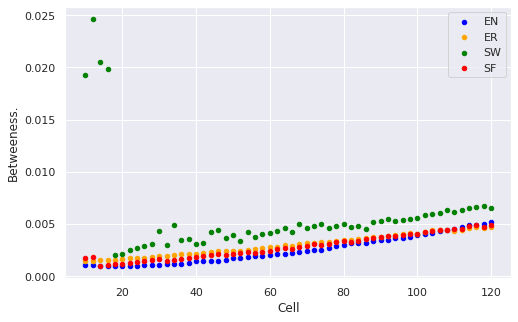

In [95]:
#grafico de promedios de betweeness
sns.set(rc={"figure.figsize":(8, 5)}) #width=8, height=4

ax1=dfmeandivergencias.plot(kind='scatter', x="tcel", y="bet", color='blue', label="EN")
ax2=dfmeandivergencias.plot(kind='scatter', x="tcel", y="betERmean", color='orange', label="ER", ax=ax1)
ax3=dfmeandivergencias.plot(kind='scatter', x="tcel", y="betSWswmean", color='green', label="SW", ax=ax1)
ax4=dfmeandivergencias.plot(kind='scatter', x="tcel", y="betSFmean", color='red', label="SF", ax=ax1)

ax1.set_xlabel('Cell')
ax1.set_ylabel('Betweeness.')


Text(0, 0.5, 'Entropia.')

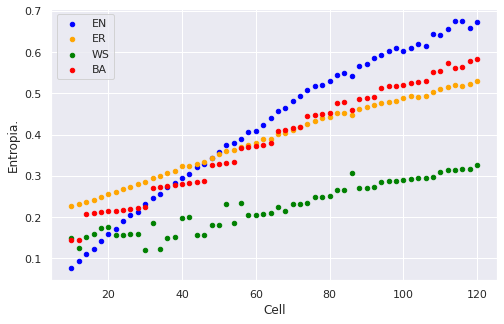

In [97]:
#grafico de promedios de entropia
sns.set(rc={"figure.figsize":(8, 5)}) #width=8, height=4

ax1=dfmeandivergencias.plot(kind='scatter', x="tcel", y="ent", color='blue', label="EN")
ax2=dfmeandivergencias.plot(kind='scatter', x="tcel", y="entERmean", color='orange', label="ER", ax=ax1)
ax3=dfmeandivergencias.plot(kind='scatter', x="tcel", y="entSWswmean", color='green', label="WS", ax=ax1)
ax4=dfmeandivergencias.plot(kind='scatter', x="tcel", y="entSFmean", color='red', label="BA", ax=ax1)

ax1.set_xlabel('Cell')
ax1.set_ylabel('Entropia.')

Text(0, 0.5, 'complejidad.')

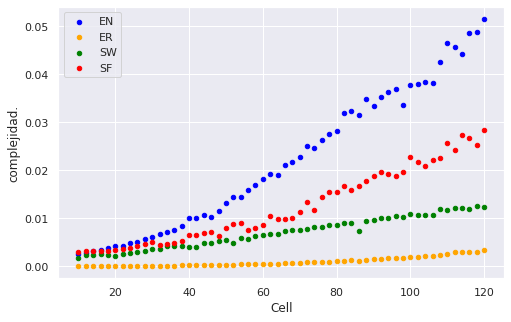

In [98]:
sns.set(rc={"figure.figsize":(8, 5)}) #width=8, height=4



#dfmeandivergencias.plot(x="tcel",y=["divENmean","divERmean","divSWmean","divSFmean"])

#fig, ax1 = plt.subplots(1,1,figsize=(16,9))

ax1=dfmeandivergencias.plot(kind='scatter', x="tcel", y="complejidad", color='blue', label="EN")
ax2=dfmeandivergencias.plot(kind='scatter', x="tcel", y="compER", color='orange', label="ER", ax=ax1)
ax3=dfmeandivergencias.plot(kind='scatter', x="tcel", y="compSWsw", color='green', label="SW", ax=ax1)
ax4=dfmeandivergencias.plot(kind='scatter', x="tcel", y="compSF", color='red', label="SF", ax=ax1)

ax1.set_xlabel('Cell')
ax1.set_ylabel('complejidad.')

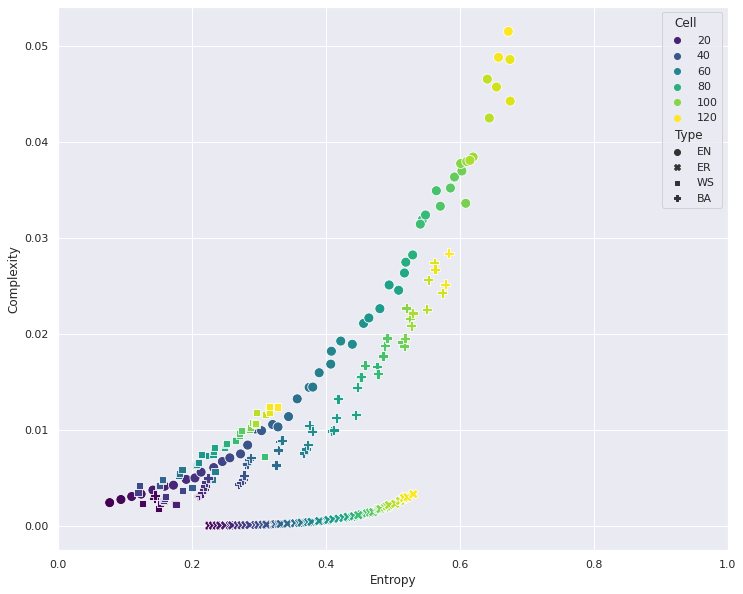

In [38]:
dfdiv1=dfmeandivergencias[["tcel","cluster","path","ent","complejidad"]].assign(tipo="EN")
dfdiv2=dfmeandivergencias[["tcel","cluERmean","patERmean","entERmean","compER"]].assign(tipo="ER")
dfdiv3=dfmeandivergencias[["tcel","cluSWswmean","patSWswmean","entSWswmean","compSWsw"]].assign(tipo="WS")
dfdiv5=dfmeandivergencias[["tcel","cluSFmean","patSFmean","entSFmean","compSF"]].assign(tipo="BA")

columnas=["Cell","Clustering","PathLength","Entropy","Complexity","Type"]
dfdiv1.columns=columnas
dfdiv2.columns=columnas
dfdiv3.columns=columnas
dfdiv5.columns=columnas
dfentscomps = pd.concat([dfdiv1, dfdiv2, dfdiv3, dfdiv5])








sns.set(rc={"figure.figsize":(12,10)})

graf=sns.scatterplot(data=dfentscomps,
                x='Entropy',
               y='Complexity',
               style='Type',
               hue='Cell',
               palette='viridis',
                s=100
               )
graf.set_xlim(0,1)

plt.savefig("complejidadvsentropia.png")

In [15]:
catalogo.to_csv("Catalogo-con-todo.csv")